# Sheet 5

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 2) Phase classification in $\phi^4$ theory

### Generate training data

Students got the code, but generating the data was not part of the exercise

In [2]:
import copy
#torch.set_default_dtype(torch.float64)
#float_dtype = np.float64

def grab(var):
    return var.detach().cpu().numpy()

In [3]:
def calc_action(
        phi: torch.Tensor,
        kap: float,
        lam: float,
        h: float):
    dims = [i+1 for i in range(len(phi.shape)-1)]
    action = (1 - 2 * lam) * phi**2 + lam * phi**4 + h * phi
    action += -2. * kap * phi * torch.roll(phi, 1, 1)
    action += -2. * kap * phi * torch.roll(phi, 1, 2)

    return torch.sum(action, dims)

def calc_force(
        phi: torch.Tensor,
        kap: float,
        lam: float,
        h: float):
    dims = [i+1 for i in range(len(phi.shape)-1)]
    force = 2 * phi * (2 * lam * (1 - phi**2) - 1) - h
    force += 2. * kap * (torch.roll(phi, 1, 1) + torch.roll(phi, -1, 1))
    force += 2. * kap * (torch.roll(phi, 1, 2) + torch.roll(phi, -1, 2))

    return force

In [4]:
def hmc(
        phi: torch.Tensor,
        action_fn,
        force_fn,
        dt: float=0.1,
        n_steps: int=10):
    """Return batch of updated phi, acceptance rate."""
    dims = [i+1 for i in range(len(phi.shape)-1)]
    S = action_fn(phi)

    new_phi = copy.deepcopy(phi)
    momentum = torch.randn(phi.shape)
    hamiltonian = 0.5 * torch.sum(momentum**2, dims) + S

    momentum += 0.5 * dt * force_fn(new_phi)
    for _ in range(n_steps-1):
        new_phi += dt * momentum
        momentum += dt * force_fn(new_phi)
    new_phi += dt * momentum
    momentum += 0.5 * dt * force_fn(new_phi)

    new_S = action_fn(new_phi)
    d_hamiltonian = 0.5 * torch.sum(momentum**2, dims) + new_S - hamiltonian

    accept = torch.rand(len(d_hamiltonian)) < torch.exp(-d_hamiltonian)
    a = accept.view(-1,1,1).repeat(1,*phi.shape[1:])

    return a * new_phi + ~a * phi, accept

In [5]:
def run_hmc(
        n_iter: int,
        phi: torch.Tensor,
        hmc_fn,
        verbose: bool=False):
    for i in range(n_iter):
        phi, _ = hmc_fn(phi)

    return phi

In [6]:
# lattice geometry

L = 16
lattice_shape = (L,L)

# HMC parameters

dt = 0.1
n_steps = 10

In [7]:
batch_size = 1000

# below phase transition (symmetric/disordered phase)

kap = 0.24
lam = 0.02
h = 0.0

symmetric_phase_data = run_hmc(
    n_iter=1000,
    phi=0.1 * torch.randn(batch_size, *lattice_shape),
    hmc_fn=lambda phi: hmc(
        phi=phi,
        action_fn=lambda phi: calc_action(phi, kap, lam, h),
        force_fn=lambda phi:calc_force(phi, kap, lam, h),
        dt=dt,
        n_steps=n_steps))

# above phase transition (broken/ordered phase)

kap = 0.3
lam = 0.02
h = 0.0

broken_phase_data = run_hmc(
    n_iter=1000,
    phi=0.1 * torch.randn(batch_size, *lattice_shape),
    hmc_fn=lambda phi: hmc(
        phi=phi,
        action_fn=lambda phi: calc_action(phi, kap, lam, h),
        force_fn=lambda phi: calc_force(phi, kap, lam, h),
        dt=dt,
        n_steps=n_steps))

In [8]:
batch_size = 100

# equidistant points crossing the phase boundary

kaps = np.arange(0.24, 0.30, 0.0025)
lam = 0.02
h = 0.0

eval_data = []

for kap in kaps:
    eval_data.append(run_hmc(
        n_iter=1000,
        phi=0.1 * torch.randn(batch_size, *lattice_shape),
        hmc_fn=lambda phi: hmc(
            phi=phi,
            action_fn=lambda phi: calc_action(phi, kap, lam, h),
            force_fn=lambda phi:calc_force(phi, kap, lam, h),
            dt=dt,
            n_steps=n_steps)))

In [9]:
train = np.stack([symmetric_phase_data.numpy(), broken_phase_data.numpy()], axis=0)
test = np.stack([eval_lattice.numpy() for eval_lattice in eval_data], axis=0)

print(train.shape)
print(test.shape)
np.save("data05/lattice_train.npy", train)
np.save("data05/lattice_test.npy", test)

(2, 1000, 16, 16)
(24, 100, 16, 16)


### Exercise begins here

(a)

In [12]:
train = np.load("data05/lattice_train.npy")
test = np.load("data05/lattice_test.npy")
kappa = np.arange(0.24, 0.30, 0.0025)

L = 16
lattice_shape = (L,L)

train, test = torch.tensor(train), torch.tensor(test)
symmetric_phase_data, broken_phase_data = train[0,...], train[1,...]

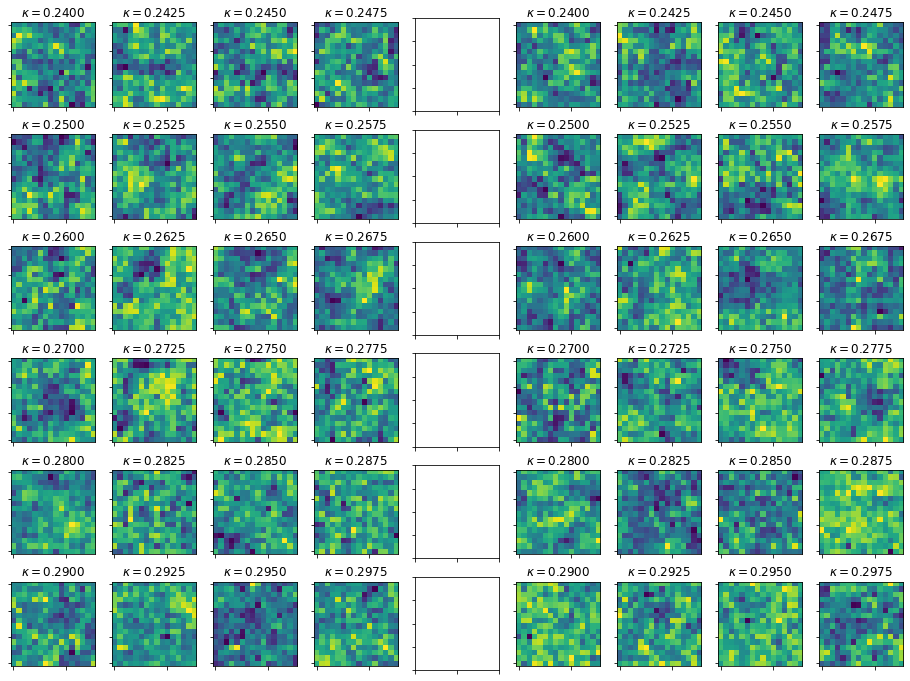

In [13]:
fig, ax = plt.subplots(6,9, figsize=(16,12))
index0 = 0
for i in range(6):
    for j in range(4):
        ax[i,j].imshow(test[i*4+j,index0,:,:])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_title(r"$\kappa = {%.4f}$" % kappa[i*4+j])
        
        ax[i,4].set_xticklabels([])
        ax[i,4].set_yticklabels([])
        
    for j in range(4):
        ax[i,j+5].imshow(test[i*4+j,index0+1,:,:])
        ax[i,j+5].set_xticklabels([])
        ax[i,j+5].set_yticklabels([])
        ax[i,j+5].set_title(r"$\kappa = {%.4f}$" % kappa[i*4+j])
plt.show()

You should not see anything meaningful in these plots

(b)

In [14]:
class Net(torch.nn.Module):
    def __init__(self, lattice_shape):
        super().__init__()
        self.lattice_shape = lattice_shape
        self.cnn = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 8, 3, padding=1, padding_mode='circular'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 8, 3, padding=1, padding_mode='circular'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 1, 3, padding=1, padding_mode='circular')])
        self.mlp = torch.nn.ModuleList([
            torch.nn.Linear(np.prod(lattice_shape), np.prod(lattice_shape)),
            torch.nn.ReLU(),
            torch.nn.Linear(np.prod(lattice_shape), 1),
            torch.nn.Sigmoid()])

    def forward(self, x):
        x = x[:,None]
        for layer in self.cnn:
            x = layer(x)
        x = x.flatten(1)
        for layer in self.mlp:
            x = layer(x)
        return x.flatten()

(c)

In [15]:
net = Net(lattice_shape)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

training_data = torch.concatenate(
    [symmetric_phase_data, broken_phase_data])
training_labels = torch.concatenate(
    [torch.zeros(len(symmetric_phase_data)),
     torch.ones(len(broken_phase_data))])

loss_vals = []
for _ in range(100):
    optimizer.zero_grad()
    out = net(training_data)
    loss = loss_fn(out, training_labels)
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())

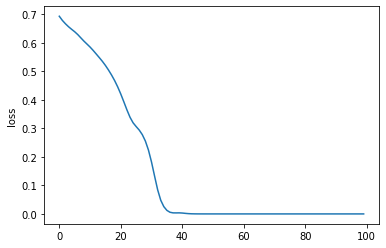

In [16]:
plt.ylabel('loss')
plt.plot(loss_vals)

(d)

In [17]:
mean_preds, std_preds = [], []
with torch.no_grad():
    for data in eval_data:
        preds = net(data)
        mean_preds.append(preds.mean().item())
        std_preds.append(preds.std().item())

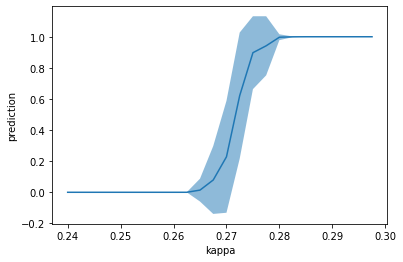

In [18]:
plt.xlabel('kappa')
plt.ylabel('prediction')
plt.plot(kaps, mean_preds)
plt.fill_between(kaps, np.array(mean_preds)+np.array(std_preds), np.array(mean_preds)-np.array(std_preds), alpha=.5)

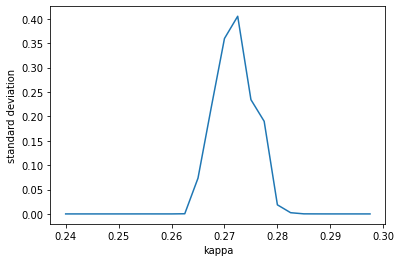

In [19]:
plt.xlabel('kappa')
plt.ylabel('standard deviation')
plt.plot(kaps, std_preds)

# 3) Bayesian Amplitude Regression

In [ ]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
%ls
os.chdir("..")

In [2]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


In [3]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [4]:
def preprocess_x(x_in, mean=None, std=None):
    x = x_in.copy() # do not overwrite
    if mean is None or std is None:
        mean = x.mean(keepdims=True)
        std = x.std(keepdims=True)
    x = (x - mean) / std # standardize
    assert np.isfinite(x).all() # check for nans and infs
    return torch.Tensor(x).float(), mean, std # create torch tensors
    
def preprocess_A(A_in, mean=None, std=None):
    A = A_in.copy()
    A = np.log(A)
    if mean is None or std is None:
        mean = A.mean(keepdims=True)
        std = A.std(keepdims=True)
    A = (A - mean) / std
    assert np.isfinite(A).all() 
    return torch.tensor(A).float().unsqueeze(-1), mean, std

def undo_preprocess_A(A_in, mean, std):
    A = A_in.copy()
    A = A * std + mean
    A = np.exp(A)
    return A

In [5]:
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [6]:
# create datasets and dataloaders
trn_datfp, mean_x, std_x = preprocess_x(trn_datf)
val_datfp, _, _ = preprocess_x(val_datf, mean_x, std_x)
tst_datfp, _, _ = preprocess_x(tst_datf, mean_x, std_x)

trn_ampp, mean_A, std_A = preprocess_A(trn_amp)
val_ampp, _, _ = preprocess_A(val_amp, mean_A, std_A)
tst_ampp, _, _ = preprocess_A(tst_amp, mean_A, std_A)

trn_dataset = amp_dataset(trn_datfp, trn_ampp)
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
class amp_net(nn.Module):
    
    def __init__(self, hdn_dim=32, ipt_dim=20, opt_dim=1, n_layers=2):
        super(amp_net, self).__init__()
        
        assert n_layers>=2
        
        layers = []
        layers.append(nn.Linear(ipt_dim, hdn_dim))
        layers.append(nn.ReLU())
        for _ in range(n_layers-2):
            layers.append(nn.Linear(hdn_dim, hdn_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim, opt_dim))
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [9]:
def train_epoch(model, dataloader, losses, batch_loss_fn):
    for x, y in dataloader:
        optimizer.zero_grad()
        
        loss = batch_loss_fn(model, x, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [10]:
def val_epoch(model, dataloader, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x, y in dataloader:
            loss = batch_loss_fn(model, x,y)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [11]:
def batch_loss(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    return loss

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters
Starting to train model 0
0 / 10


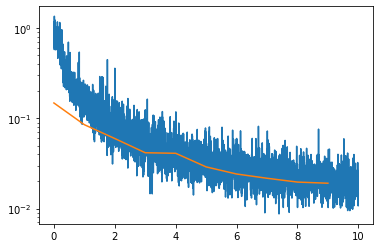

Starting to train model 1
0 / 10


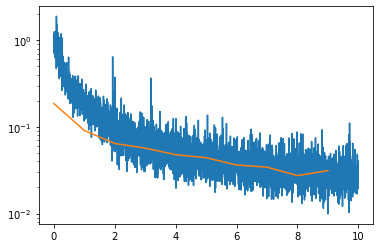

Starting to train model 2
0 / 10


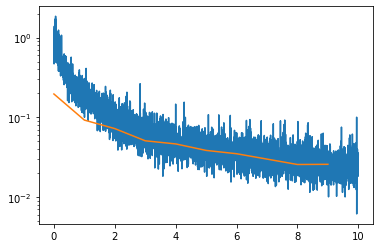

Starting to train model 3
0 / 10


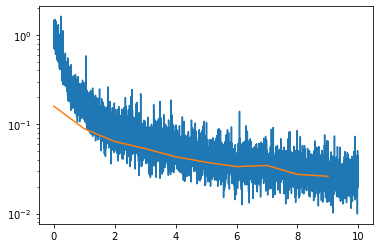

Starting to train model 4
0 / 10


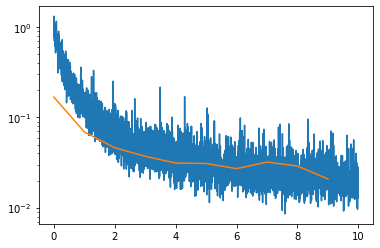

Starting to train model 5
0 / 10


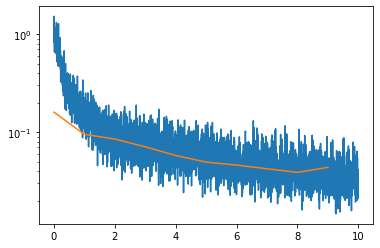

Starting to train model 6
0 / 10


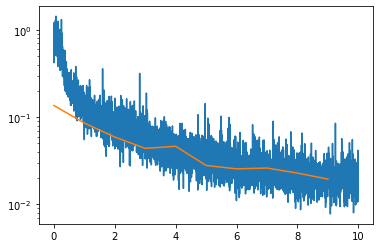

Starting to train model 7
0 / 10


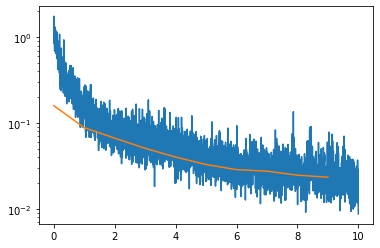

Starting to train model 8
0 / 10


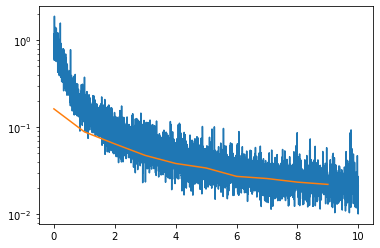

Starting to train model 9
0 / 10


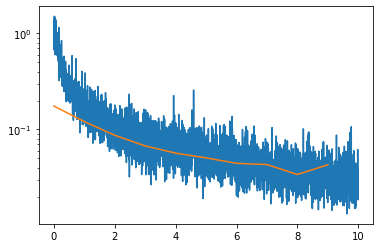

In [12]:
n_epochs = 10
loss_fn = nn.MSELoss()

n_models = 10
models = []
for imodel in range(n_models):
    model = amp_net(hdn_dim=32, n_layers=4).to(device)

    if imodel==0:
        print(model)
        total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {total_parameters:d} trainable parameters")
    
    print(f"Starting to train model {imodel}")
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
        val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
        if epoch%10==0:
            print(f"{epoch} / {n_epochs}")
            
    models.append(model)
    
    plt.yscale("log")
    plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.show()

In [13]:
# calculate predictions
preds = []
with torch.no_grad():
    for i in range(n_models):
        model = models[i]
        preds_single = np.array([])
        for x, y in tst_dataloader:
            pred = model(x)
            preds_single = np.append(preds_single, pred)
        preds_single = undo_preprocess_A(preds_single, mean_A, std_A) 
        preds.append(preds_single)
preds = np.stack(preds, axis=0)

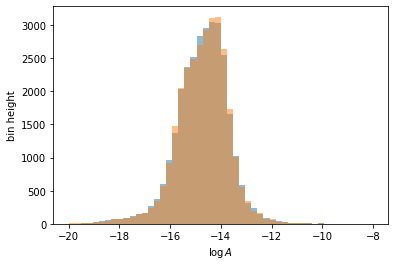

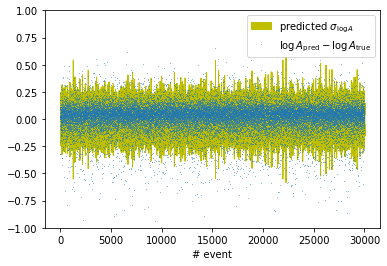

In [14]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

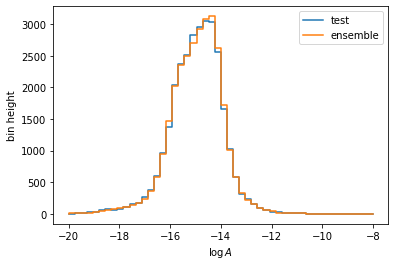

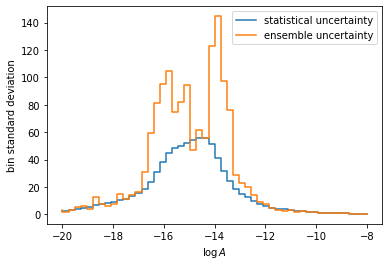

<ipython-input-23-de7f1ef923ca>:38: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
<ipython-input-23-de7f1ef923ca>:39: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
<ipython-input-23-de7f1ef923ca>:38: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


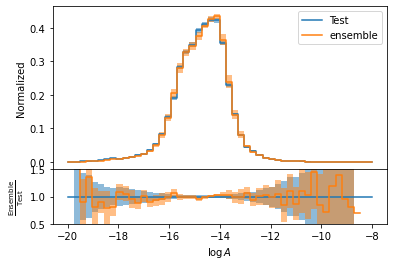

In [23]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

(d)

In [24]:
import math

class VBLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False, std_init=-5):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec # = 1/sigma_prior**2
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features)) # log(sigma_network**2)
        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-11, 11)
        kl = 0.5 * (self.prior_prec * (self.mu_w.pow(2) + logsig2_w.exp())
                - logsig2_w - 1 - np.log(self.prior_prec)).sum() #let students fill this in
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map: # just return the mean, no sampling
                return nn.functional.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(-11, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias) + 1e-8

In [25]:
class bayesian_amp_net(nn.Module):
    
    def __init__(self, training_size, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        super(bayesian_amp_net, self).__init__()
        
        assert n_layers>=2
        self.training_size = training_size
        
        layers = []
        self.bayesian_layers = []
        linear = VBLinear(ipt_dim, hdn_dim)
        layers.append(linear)
        self.bayesian_layers.append(linear)
        layers.append(nn.ReLU())
        for _ in range(n_layers-2):
            linear = VBLinear(hdn_dim, hdn_dim)
            layers.append(linear)
            self.bayesian_layers.append(linear)
            layers.append(nn.ReLU())
        linear = VBLinear(hdn_dim, opt_dim)
        layers.append(linear)
        self.bayesian_layers.append(linear)
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out
    
    def KL(self):
        kl = 0
        for layer in self.bayesian_layers:
            kl += layer.KL()
        return kl
    
    def reset_BNN(self):
        for layer in self.bayesian_layers:
            layer.random = None

In [26]:
def batch_loss_bayesian(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    kl = model.KL() / trn_dat.shape[0]
    loss += kl
    return loss

In [27]:
n_epochs = 100
loss_fn = nn.MSELoss()

bnn = bayesian_amp_net(trn_dat.shape[0], hdn_dim=32, n_layers=4).to(device)
print(bnn)
total_parameters = sum(p.numel() for p in bnn.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(bnn.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(bnn, trn_dataloader, train_losses, batch_loss_bayesian)
    
    val_losses = val_epoch(bnn, val_dataloader, val_losses, batch_loss_bayesian)
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

bayesian_amp_net(
  (linear_relu_stack): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)
Model has 5537 trainable parameters
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


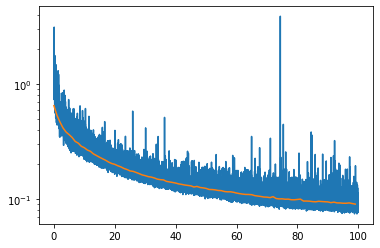

In [28]:
plt.yscale("log")
plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.show()

In [29]:
# calculate predictions
iterations = 30
preds = []

bnn.eval() # use bnn in evaluation mode 
with torch.no_grad(): # no need for gradients here
    for i in range(iterations):
        bnn.reset_BNN()
        preds_single = np.array([])
        for x, y in tst_dataloader:
            pred = bnn(x)
            preds_single = np.append(preds_single, pred)
        preds_single = undo_preprocess_A(preds_single, mean_A, std_A) 
        preds.append(preds_single)
preds = np.stack(preds, axis=0)

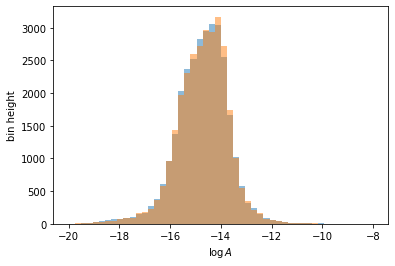

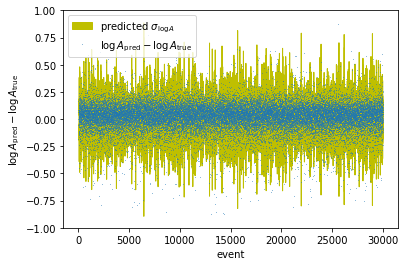

In [30]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.ylabel(r"$\log A_\mathrm{pred} - \log A_\mathrm{true}$")
plt.xlabel("event")
plt.ylim(-1,1)
plt.legend()
plt.show()

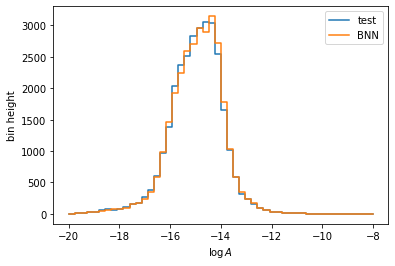

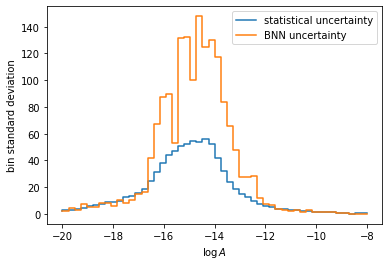

<ipython-input-31-7fbac0821a1d>:38: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
<ipython-input-31-7fbac0821a1d>:39: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
<ipython-input-31-7fbac0821a1d>:38: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


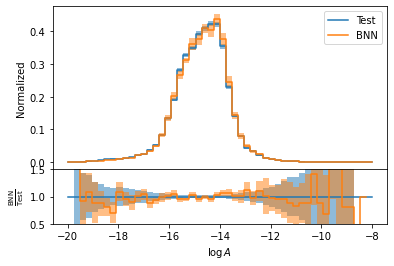

In [31]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="BNN")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="BNN uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "BNN"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{BNN}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()